# Creating The Model

## 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Import Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 3. Check GPU availability

In [3]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 4. Dataset Paths

In [4]:
data_dir = "/content/drive/My Drive/My_Plant_Proj/Dataset/Dataset"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"

## 5. Image and training parameters

In [5]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
MAX_PER_CLASS = 180  # 180 images per class

## 6. Function to collect limited images per class

In [6]:
def get_limited_image_paths(directory, max_per_class=180):
    image_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            all_images = os.listdir(class_path)
            selected_images = all_images[:max_per_class]
            for img in selected_images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    return pd.DataFrame({"filename": image_paths, "class": labels})

## 7. Create DataFrame for training & validation

In [7]:
train_df = get_limited_image_paths(train_dir, MAX_PER_CLASS)
valid_df = get_limited_image_paths(valid_dir, MAX_PER_CLASS)

## 8. Data Generators

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

Found 3600 validated image filenames belonging to 20 classes.
Found 3600 validated image filenames belonging to 20 classes.


## 9. Get number of classes

In [9]:
num_classes = len(train_generator.class_indices)

## 10. Define and Train Model (DenseNet121)


In [10]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 11. Train Model

In [11]:
history = model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2135s 37s/step - accuracy: 0.4798 - loss: 1.9180 - val_accuracy: 0.8369 - val_loss: 0.5065
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - accuracy: 0.9253 - loss: 0.2774 - val_accuracy: 0.8917 - val_loss: 0.3490
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.9674 - loss: 0.1445 - val_accuracy: 0.9133 - val_loss: 0.2841
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - accuracy: 0.9756 - loss: 0.1115 - val_accuracy: 0.9153 - val_loss: 0.2805
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - accuracy: 0.9814 - loss: 0.0871 - val_accuracy: 0.9347 - val_loss: 0.2329
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 593ms/step - accuracy: 0.9916 - loss: 0.0584 - val_accuracy: 0.9328 - val_loss: 0.2286
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - accuracy: 0.9913 - loss: 0.0519 - val_accuracy: 0.9344 - val_loss: 0.2217
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 446ms/step - accuracy: 0.9925 - loss: 0.0434 - val_accu

## 12. Save Model

In [12]:
# model.save("/content/drive/My Drive/My_Plant_Proj/Dataset/densenet121_fast.h5")

# Graphical visualisations and results

In [18]:
# Plot Accuracy & Loss
plt.style.use("ggplot")
colors = ["#ff6361", "#bc5090", "#ffa600", "#58508d", "#003f5c", "#44bd32"]
plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

## 1. Accuracy Plot

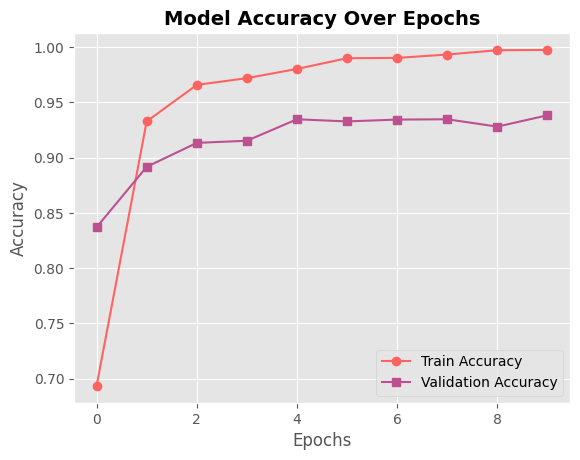

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color=colors[0])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color=colors[1])
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

## 2. Loss Plot

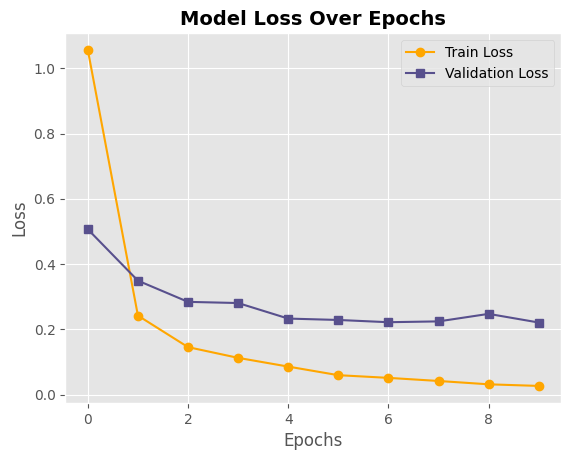

In [20]:
plt.plot(history.history['loss'], label='Train Loss', marker='o', color=colors[2])
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color=colors[3])
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## 3. Train vs. Validation Loss Difference

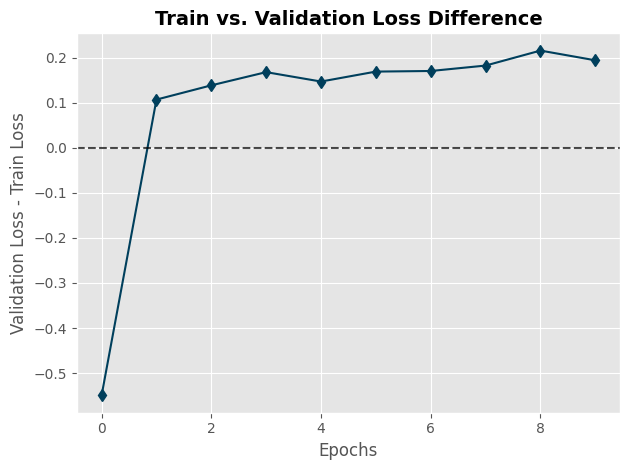

In [21]:
loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
plt.plot(loss_diff, marker='d', color=colors[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('Train vs. Validation Loss Difference', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss - Train Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Class Distribution

<ipython-input-22-f0633d94371b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


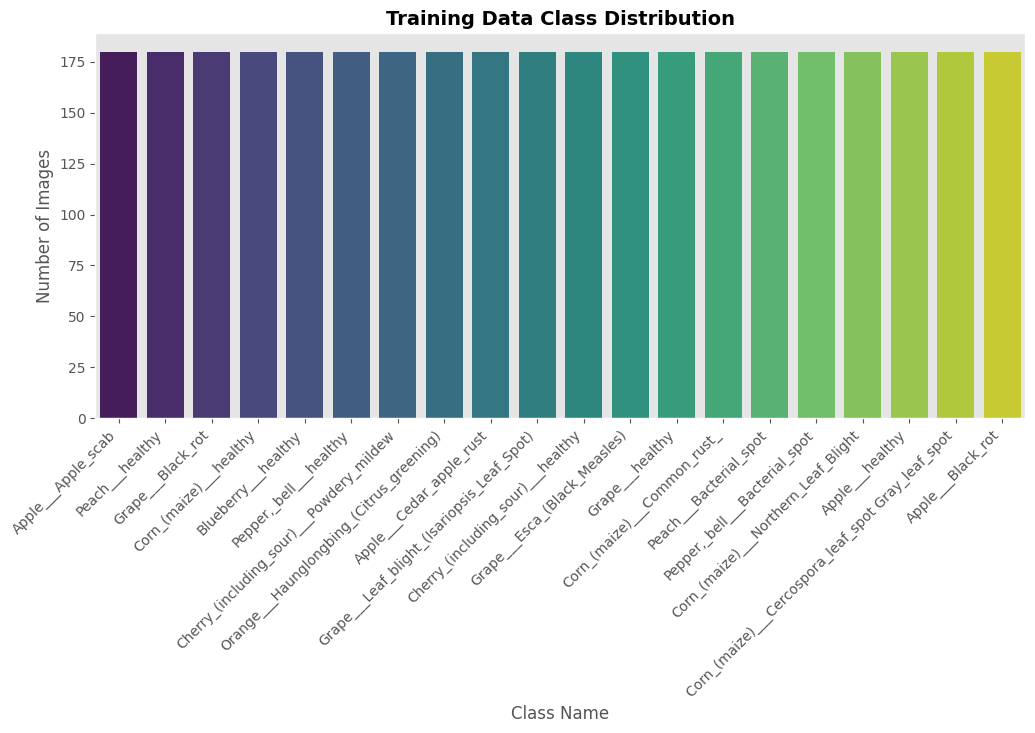

In [22]:
plt.figure(figsize=(12, 5))
class_counts = train_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Training Data Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()